In [12]:
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer, BitsAndBytesConfig, pipeline
from transformers.pipelines.pt_utils import KeyDataset
from peft import PeftModel, PeftConfig
from dotenv import dotenv_values
import torch
from tqdm.auto import tqdm
import evaluate

from utils import DataPreprocessor, DatasetFormatConverter
from utils import DataPreprocessor

from src.billm import LlamaForTokenClassification

WANDB_KEY = dotenv_values(".env.base")['WANDB_KEY']
LLAMA_TOKEN = dotenv_values(".env.base")['LLAMA_TOKEN']
HF_TOKEN = dotenv_values(".env.base")['HF_TOKEN']

adapters = "ferrazzipietro/LS_Llama-2-7b-hf_adapters_en.layer1_NoQuant_64_64_0.01_2_0.0002"
peft_config = PeftConfig.from_pretrained(adapters)
BASE_MODEL_CHECKPOINT = peft_config.base_model_name_or_path

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_CHECKPOINT,token =HF_TOKEN)
tokenizer.pad_token = tokenizer.eos_token
# seqeval = evaluate.load("seqeval")
DATASET_CHEKPOINT="ferrazzipietro/e3c-sentences" 
TRAIN_LAYER="en.layer1"
preprocessor = DataPreprocessor(BASE_MODEL_CHECKPOINT, 
                                tokenizer)
dataset = load_dataset(DATASET_CHEKPOINT) #download_mode="force_redownload"
dataset = dataset[TRAIN_LAYER]
dataset = dataset.shuffle(seed=1234)  
dataset_format_converter = DatasetFormatConverter(dataset)
dataset_format_converter.apply()
ds = dataset_format_converter.dataset
label2id = dataset_format_converter.label2id
id2label = dataset_format_converter.get_id2label()
label_list = dataset_format_converter.get_label_list()
dataset_format_converter.set_tokenizer(tokenizer)
dataset_format_converter.set_max_seq_length(256)
tokenized_ds = ds.map(lambda x: dataset_format_converter.tokenize_and_align_labels(x), batched=True)# dataset_format_converter.dataset.map(tokenize_and_align_labels, batched=True)
train_data, val_data, test_data = preprocessor.split_layer_into_train_val_test_(tokenized_ds, TRAIN_LAYER)


In [14]:
train_data

Dataset({
    features: ['sentence', 'entities', 'original_text', 'original_id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 669
})

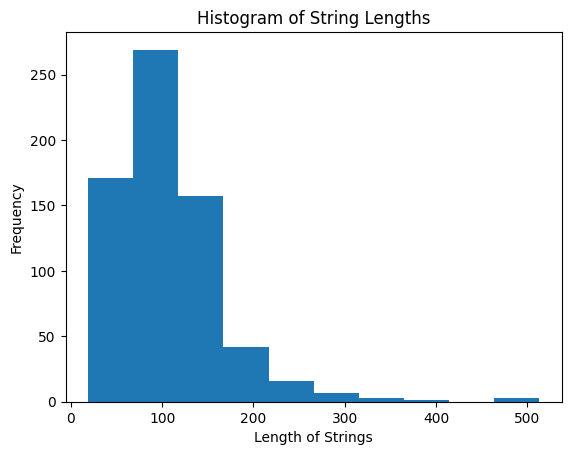

In [3]:
import matplotlib.pyplot as plt

# Get the lengths of the strings
lengths = [len(sentence) for sentence in train_data['sentence']]

# Plot the histogram
plt.hist(lengths, bins=10)
plt.xlabel('Length of Strings')
plt.ylabel('Frequency')
plt.title('Histogram of String Lengths')
plt.show()

In [15]:
bnb_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.bfloat16,
                )

model = LlamaForTokenClassification.from_pretrained(
    peft_config.base_model_name_or_path,
    num_labels=len(label2id), id2label=id2label, label2id=label2id,
    token = HF_TOKEN,
    cache_dir='/data/disk1/share/pferrazzi/.cache',
    device_map='auto',
    quantization_config = bnb_config)
model = PeftModel.from_pretrained(model, adapters, token = HF_TOKEN)
model = model.merge_and_unload()

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]
Some weights of LlamaForTokenClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.
/home/pferrazzi/LS-LLaMA-E3C/.venv/lib/python3.11/site-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [71]:
model_output_logits = generated_ids.logits[0].cpu().detach().float().numpy()    
predictions = np.argmax(model_output_logits, axis=2)
print(predictions)
[[label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip([0,1,1,1,2,2,0,2], [0,1,1,0,0,0,0,2])
    ]

AxisError: axis 2 is out of bounds for array of dimension 2

In [66]:

seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    print(results)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [81]:
len( ['O', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'I', 'B', 'I', 'I', 'B', 'I', 'I', 'O', 'B', 'O', 'I', 'O', 'B', 'I', 'I', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'I', 'I', 'O', 'B', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'I', 'O', 'I', 'I', 'I'])

68

In [67]:
examples = [train_data['sentence'][0] , train_data['sentence'][5]]
input_sentences = examples
encodeds = tokenizer(input_sentences, return_tensors="pt", add_special_tokens=True, padding=True)
model_inputs = encodeds.to('cuda')
generated_ids = model(**model_inputs)
compute_metrics(generated_ids)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
gen = OutputGeneration(model, tokenizer, id2label)
pl = gen._create_prediction_list(generated_ids)

In [6]:
for i, s in enumerate([0,5]):
    print((train_data[s]['sentence']))
    print(f"n words in sentence: {len(train_data[s]['sentence'].split())}")
    print(f"len_ sentence: {len(train_data[s]['sentence'])}")
    print(f"n tokens with labels: {len(train_data[s]['labels'])}")
    print(f"n  created labels: {len(generated_ids['logits'][i])}")

Their child acquired walking at the age of 14 months.
n words in sentence: 10
len_ sentence: 53
n tokens with labels: 14
n  created labels: 78
Pertinent laboratory studies included a hemoglobin level of 10 g/dL, platelet count was normal, blood urea of 1,2 g/l (0,18-0,45 g/L), and a creatinine level of 68 mg/L (7-13 mg/L).
n words in sentence: 30
len_ sentence: 181
n tokens with labels: 78
n  created labels: 78


In [25]:
import pandas as pd


token_classifier = pipeline("token-classification", model=model, 
                            tokenizer=tokenizer, 
                            aggregation_strategy="simple", batch_size=12)
token_classifier(train_data[0]['sentence'])
l = []
for out in tqdm(token_classifier(KeyDataset(train_data.select(range(24)), "sentence"))):
    l.append(out)

tmp = train_data.select(range(24)).add_column('model_output', l)
tmp[6]['model_output']

The model 'LlamaForTokenClassification' is not supported for token-classification. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GPT2ForTokenClassification', 'GPT2ForTokenClassification', 'GPTBigCodeForTokenClassification', 'GPTNeoForTokenClassification', 'GPTNeoXForTokenClassification', 'IBertForTokenClassification', 'LayoutLMForTokenCl

RuntimeError: The expanded size of the tensor (14) must match the existing size (4096) at non-singleton dimension 2.  Target sizes: [1, 32, 14, 14].  Tensor sizes: [1, 1, 4096, 14]

In [20]:
print(train_data[0]['tokens'])
example = train_data[0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['Their', 'child', 'acquired', 'walking', 'at', 'the', 'age', 'of', '14', 'months.']


['<s>',
 '▁Their',
 '▁child',
 '▁acquired',
 '▁walking',
 '▁at',
 '▁the',
 '▁age',
 '▁of',
 '▁',
 '1',
 '4',
 '▁months',
 '.']

In [32]:
import pandas as pd


token_classifier = pipeline("ner", model=model, 
                            tokenizer=tokenizer, 
                            aggregation_strategy="simple", batch_size=12)


#token_classifier(train_data[0]['tokens'])
l = []
for out in tqdm(token_classifier(KeyDataset(train_data.select(range(24)), "sentence"))):
    l.append(out)

tmp = train_data.select(range(24)).add_column('model_output', l)
tmp[6]['model_output']

The model 'LlamaForTokenClassification' is not supported for ner. Supported models are ['AlbertForTokenClassification', 'BertForTokenClassification', 'BigBirdForTokenClassification', 'BioGptForTokenClassification', 'BloomForTokenClassification', 'BrosForTokenClassification', 'CamembertForTokenClassification', 'CanineForTokenClassification', 'ConvBertForTokenClassification', 'Data2VecTextForTokenClassification', 'DebertaForTokenClassification', 'DebertaV2ForTokenClassification', 'DistilBertForTokenClassification', 'ElectraForTokenClassification', 'ErnieForTokenClassification', 'ErnieMForTokenClassification', 'EsmForTokenClassification', 'FalconForTokenClassification', 'FlaubertForTokenClassification', 'FNetForTokenClassification', 'FunnelForTokenClassification', 'GPT2ForTokenClassification', 'GPT2ForTokenClassification', 'GPTBigCodeForTokenClassification', 'GPTNeoForTokenClassification', 'GPTNeoXForTokenClassification', 'IBertForTokenClassification', 'LayoutLMForTokenClassification', 'L

[{'end': 24,
  'entity_group': 'B',
  'score': 0.657,
  'start': 7,
  'word': 'assessment found'},
 {'end': 38,
  'entity_group': 'B',
  'score': 0.794,
  'start': 32,
  'word': 'score'},
 {'end': 44,
  'entity_group': 'B',
  'score': 0.6616,
  'start': 40,
  'word': 'GCS)'},
 {'end': 48, 'entity_group': 'B', 'score': 0.6094, 'start': 47, 'word': ''},
 {'end': 52, 'entity_group': 'I', 'score': 0.585, 'start': 51, 'word': '1'},
 {'end': 53, 'entity_group': 'B', 'score': 0.572, 'start': 52, 'word': '5'},
 {'end': 66,
  'entity_group': 'B',
  'score': 0.824,
  'start': 55,
  'word': 'eye opening'},
 {'end': 70, 'entity_group': 'B', 'score': 0.708, 'start': 69, 'word': ''},
 {'end': 72, 'entity_group': 'B', 'score': 0.4004, 'start': 71, 'word': ','},
 {'end': 88,
  'entity_group': 'B',
  'score': 0.628,
  'start': 76,
  'word': 'bal response'},
 {'end': 93, 'entity_group': 'B', 'score': 0.6816, 'start': 91, 'word': '2'},
 {'end': 100,
  'entity_group': 'I',
  'score': 0.623,
  'start': 94,

In [18]:
import pandas as pd
import ast
import evaluate
seqeval = evaluate.load("seqeval")
data = load_dataset("csv", data_files="data/evaluation/train_data_LS_Mistral-7B-v0.1_adapters_en.layer1_NoQuant_16_32_0.01_2_0.0002.csv")
def helper(example):
    example['model_output'] = ast.literal_eval(example['model_output'].replace('\n', ','))
    return example
data = data.map(lambda x: helper(x))



In [ ]:

    def _extract_TP_FP_FN(self, model_response: str, ground_truth: str, similar_is_equal:bool=True, similar_is_equal_threshold: int=100, similarity_types:'list[str]'=['case', 'stop_words', 'subset', 'superset', 'leveshtein'], words_level:bool=True) -> [int, int, int]:
        """
        Compute the F1 score, the precision and the recall between the model output and the ground truth

        Args:
        model_response (str): the model output as it is returned by the model
        ground_truth (str): the ground truth in json format.
        similar_is_equal (bool): if True, the function will consider similar entities as equal. The default value is False.
        similar_is_equal_threshold (int): the threshold to consider the entities similar. The default value is 80. 0 is completely different, 100 is the same.
        words_level (bool): if True, the function will consider as base elements the words. If False, the function will consider as base elements the entity. 
        E.g., if True, the original sentence is "Yesterday morning I was so very happy and sad", the ground truth is ["yesterday morning", "so very happy"] the model output is ["morning", "happy and"], the function will consider FP=2 ("and"); TP=1 ("morning", "happy"); FN=2 ("Yesterday", "so"). 
        If False, the function will consider FP=1 ("happy and"); TP=0; FN=2 ("Yesterday morning", "so very happy").
        similarity_types: the list of similarity types to consider. Must contain elements in ['case', 'stop_words', 'subset', 'superset', 'leveshtein']

        """
        # print('ORIGINAL model_response: ', model_response)
        model_response = self._parse_json(model_response)
        # print('GROUND TRUTH: ', ground_truth)
        ground_truth = self._parse_json(ground_truth.replace('\n', ''))
        model_response = model_response["entities"]
        ground_truth = ground_truth["entities"]
        # print('PARSED ORIGINAL model_response: ', model_response)
        if not similar_is_equal:
            similarity_types = []

        if words_level:
            FP_sum = 0
            FN_sum = 0
            TP_sum = 0
            identified_entities_list = []
            for i, response_entity in enumerate(model_response):
                entity_identified, FP, FN, TP= self.entity_in_ground_truth_list(response_entity, ground_truth, model_response, similar_is_equal_threshold, similarity_types)
                FP_sum += FP
                FN_sum += FN
                TP_sum += TP
                identified_entities_list.append(entity_identified)
            FN_entities = set(ground_truth).difference(set(identified_entities_list))
            FN_entities = [entity.split() for entity in FN_entities]
            FN_entities = [item for row in FN_entities for item in row]
            # print('FALSE NEGATIVES: ', FN_entities)
            FN_sum += len(FN_entities)
            #print('PARSED GROUND TRUTH: ', ground_truth, 'TP_sum:', TP_sum, 'FP_sum:', FP_sum, 'FN_sum:', FN_sum, '\n\n')
            return [TP_sum, FP_sum, FN_sum]
           
        elif not words_level:
            for i, response_entity in enumerate(model_response):
                model_response[i], _, _, _= self.entity_in_ground_truth_list(response_entity, ground_truth, model_response, similar_is_equal_threshold, similarity_types)
            #print('PARSED GROUND TRUTH: ', ground_truth)
            #print('NEW model_response to calculate TP, FP, FN: ', model_response, '\n\n')

            TP = len(set(model_response).intersection(set(ground_truth)))
            FP = len(set(model_response).difference(set(ground_truth)))
            FN = len(set(ground_truth).difference(set(model_response)))
            # F1 = 2 * TP / (2 * TP + FN + FP)
            return [TP, FP, FN]
    
    def generate_evaluation_table(self, similar_is_equal_threshold: int, words_level:bool, similarity_types:'list[str]') -> dict:
        """
        Generate the evaluation table for the model output and the ground truth.

        Args:
        similar_is_equal_threshold (int): the threshold to consider the entities similar by the Leveshtein distance. The default value is 80. 0 is completely
        different, 100 is the same. 
        words_level (bool): if True, the function will consider as base elements the words. If False, the function will consider as base elements the entity. 
        E.g., if True, the original sentence is "Yesterday morning I was so very happy and sad", the ground truth is ["yesterday morning", "so very happy"] the model output is ["morning", "happy and"], the function will consider FP=2 ("and"); TP=1 ("morning", "happy"); FN=2 ("Yesterday", "so"). 
        If False, the function will consider FP=1 ("happy and"); TP=0; FN=2 ("Yesterday morning", "so very happy").
        similarity_types: the list of similarity types to consider. Must contain elements in ['case', 'stop_words', 'subset', 'superset', 'leveshtein']

        return:
        dict: the evaluation table
        """
        metrics_list = []
        for i, res in enumerate(self.data['model_output']):
           #  if self.cleaner.verbose: print('res:', res)
            metrics_list.append(self._extract_TP_FP_FN(res, self.data['ground_truth'][i], True, similar_is_equal_threshold, similarity_types, words_level))

        metrics_dataframe = pd.DataFrame(metrics_list, columns=['TP', 'FP', 'FN'])
        summary = metrics_dataframe.sum()
        precision = summary['TP'] / (summary['TP'] + summary['FP'])
        recall = summary['TP'] / (summary['TP'] + summary['FN'])
        f1 = 2 * (precision * recall) / (precision + recall)
        self.evaluation_table = {'evaluation': metrics_dataframe, 'precision':precision, 'recall':recall, 'f1':f1}
        return {'evaluation': metrics_dataframe, 'precision':precision, 'recall':recall, 'f1':f1}

In [54]:

def compute_metrics(logits, labels):
    model_output_logits = logits.cpu().detach().float().numpy()    
    predictions = np.argmax(model_output_logits, axis=1)
    print(predictions)
    print(len(predictions))
    print(len(labels))
    #labels = [labels*attn_mask for labels, attn_mask in zip(labels, attention_mask[:len(labels)])]
    # predicted_labels = []
    # for i in range(len(labels)):
    #     print('pred: ', predictions[i], 'label: ', labels[i])
    #     if labels[i] != -100:
    #      predicted_labels.append(id2label[predictions[i]])
    # print('labels predictions: ', predicted_labels)

    predicted_labels = [id2label[prediction] for i, prediction in enumerate(predictions[:len(labels)]) if labels[i] != -100 ]
    labels = [id2label[label] for label in labels if label != -100]
    print('labels: ', labels)
    print('predictions: ', predicted_labels)

    results = seqeval.compute(predictions=predicted_labels, references=labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["soverall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [46]:
print(train_data[0]['sentence'])
print(tokenizer(train_data[0]['sentence']))
encodeds

Their child acquired walking at the age of 14 months.
{'input_ids': [1, 11275, 2278, 16692, 22049, 472, 278, 5046, 310, 29871, 29896, 29946, 7378, 29889], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


{'input_ids': tensor([[    1, 11275,  2278, 16692, 22049,   472,   278,  5046,   310, 29871,
         29896, 29946,  7378, 29889,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2],
        [    1,   349,   814,  8946, 10212,  7606, 11898,  5134,   263,  9736,
           468,   417,  2109,  3233,   310, 29871, 29896, 29900,   330, 29914,
         29881, 29931, 29892, 15284,  1026,  2302,   471,  4226, 29892, 10416,
           318,  5638,   310, 29871, 29896, 29892, 29906,   330, 29914, 29880,
           313, 29900, 29892, 29896, 29947, 29899, 

In [55]:
examples = [train_data['sentence'][15], train_data['sentence'][5]]
input_sentences = examples
encodeds = tokenizer(input_sentences, return_tensors="pt", add_special_tokens=True, padding=True)
model_inputs = encodeds.to('cuda')
generated_ids = model(**model_inputs)
compute_metrics(generated_ids['logits'][0],   train_data[0]['labels'])

[1 1 2 2 2 0 0 0 0 0 0 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]
78
14
labels:  ['B', 'I', 'B', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
predictions:  ['B', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'O', 'O']


ValueError: Got a string but expected a list instead: 'B'

In [85]:
tp = [['O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'I'], ['O', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'I', 'B', 'I', 'I', 'B', 'I', 'I', 'O', 'B', 'O', 'I', 'O', 'B', 'I', 'I', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'I', 'I', 'O', 'B', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'I', 'O', 'I', 'I', 'I'], ['I', 'O', 'O', 'O', 'B', 'O', 'B', 'I', 'B', 'O', 'O', 'O', 'I', 'I', 'O', 'I', 'O', 'O', 'O', 'O', 'I', 'O', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'O', 'I', 'I', 'O', 'O', 'O', 'I', 'I', 'I', 'O', 'I', 'O', 'I', 'O', 'O', 'B', 'B', 'I', 'O'], ['I', 'I', 'I', 'I', 'O', 'I', 'I', 'B', 'O', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'O', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'I', 'I'], ['O', 'O', 'O', 'I', 'B', 'I', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'O', 'O', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'B', 'B', 'I', 'O', 'O', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'], ['I', 'O', 'O', 'I', 'I', 'O', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'I', 'B', 'O', 'O', 'O', 'I', 'I', 'I', 'B', 'B', 'B', 'I', 'O', 'I', 'O', 'O', 'O', 'I', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'I', 'I'], ['O', 'B', 'I', 'O', 'I', 'I', 'O', 'O', 'I', 'I', 'B', 'O', 'B', 'B', 'O', 'I', 'I', 'I', 'O', 'I', 'O', 'O', 'B', 'I', 'B', 'B', 'I', 'I', 'O', 'I', 'O', 'B', 'O', 'B', 'B', 'I', 'O', 'I', 'I'], ['O', 'I', 'O', 'I', 'O', 'O', 'O', 'O', 'I'], ['O', 'I', 'O', 'B', 'O', 'I', 'O', 'I', 'O', 'O', 'I', 'B', 'B', 'B', 'B', 'B', 'I', 'I', 'I', 'O', 'I', 'B', 'I', 'I', 'I', 'O', 'O', 'O', 'I', 'O', 'I', 'B', 'O', 'I', 'B', 'I', 'I', 'I'], ['B', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'I', 'B', 'O', 'O', 'O', 'O', 'I', 'O', 'I', 'O', 'O', 'O', 'B', 'B', 'O', 'I', 'O', 'O', 'O', 'O', 'B', 'B', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'O', 'B', 'I', 'I', 'I'], ['O', 'I', 'O', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'I', 'O', 'I', 'I', 'I', 'O', 'B', 'I', 'O', 'B', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'O', 'O', 'B', 'I', 'O', 'O', 'B', 'I', 'O', 'B', 'I', 'I', 'O', 'I', 'I'], ['B', 'B', 'I', 'I', 'I', 'O', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'I', 'I', 'I', 'I', 'I', 'B', 'O', 'O', 'I', 'I']]
tl = [['O', 'O', 'O', 'O', 'B', 'I', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'], ['O', 'B', 'I', 'I', 'O', 'B', 'I', 'I', 'B', 'O', 'B', 'I', 'I', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'B', 'I', 'I', 'I', 'B', 'I', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'I'], ['B', 'O', 'O', 'B', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'B', 'I', 'I', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'B', 'I', 'I', 'I', 'I'], ['B', 'I', 'I', 'I', 'I', 'I', 'B', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'B', 'I', 'I', 'O', 'B', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'I', 'O', 'B', 'O', 'B', 'I', 'I', 'I', 'I', 'I'], ['O', 'O', 'O', 'O', 'B', 'I', 'B', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'B', 'B', 'I', 'B', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'B', 'O', 'B', 'I', 'I', 'O', 'O', 'B', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'B', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I'], ['O', 'O', 'O', 'B', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'B', 'B', 'O', 'B', 'I', 'I', 'I', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I'], ['O', 'B', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'B', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I'], ['O', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'I'], ['O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'B', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'B', 'O', 'B', 'I', 'B', 'O', 'B', 'I', 'I', 'I', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'I', 'I'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'B', 'I', 'I', 'B', 'I', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'I', 'O', 'O', 'O'], ['B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'B', 'I', 'B', 'I', 'I', 'B', 'I', 'I', 'I', 'I', 'O', 'B', 'B', 'I', 'I', 'I', 'I']]

In [86]:
seqeval.compute(predictions=tp, references=tl)

{'_': {'precision': 0.09701492537313433,
  'recall': 0.15294117647058825,
  'f1': 0.11872146118721462,
  'number': 85},
 'overall_precision': 0.09701492537313433,
 'overall_recall': 0.15294117647058825,
 'overall_f1': 0.11872146118721462,
 'overall_accuracy': 0.5340699815837937}

In [154]:
len(tp)

batch = train_data.select(range(12))
examples = batch['sentence']
encodeds = tokenizer(examples, return_tensors="pt", add_special_tokens=True, padding=True)
model_inputs = encodeds.to('cuda')
generated_ids = model(**model_inputs)
print(generated_ids.logits)

max_length = 169
padded_labels = [sublist + [-100] * (max_length - len(sublist)) for sublist in batch['labels']]
padded_labels = np.array(padded_labels)

tensor([[[-0.2700,  2.4688,  0.4968],
         [ 0.6313, -0.3750, -3.3027],
         [-2.2402, -1.0303,  0.9199],
         ...,
         [ 0.2050,  0.9761, -0.6738],
         [ 0.2134,  0.9766, -0.6865],
         [ 0.2212,  0.9888, -0.7046]],

        [[-0.2700,  2.4688,  0.4968],
         [ 3.6992,  2.4766, -0.1819],
         [ 2.0234, -0.4658, -0.5229],
         ...,
         [ 0.5977,  0.6646, -0.5928],
         [ 0.6367,  0.6826, -0.5869],
         [ 0.6914,  0.6958, -0.5732]],

        [[-0.2700,  2.4688,  0.4968],
         [ 1.3906,  1.1963, -2.3613],
         [ 0.9155,  0.4763, -1.0371],
         ...,
         [ 0.2817,  2.0430, -0.4761],
         [ 0.2883,  2.0684, -0.5220],
         [ 0.3015,  2.0840, -0.5698]],

        ...,

        [[-0.2700,  2.4688,  0.4968],
         [ 2.6270,  1.6318, -1.8018],
         [ 2.4648, -1.9111, -1.4434],
         ...,
         [ 0.2754,  0.8252, -0.7539],
         [ 0.2749,  0.8208, -0.7495],
         [ 0.2856,  0.8423, -0.7407]],

        [[

In [166]:
class OutputGeneration():
    def __init__(self, model, tokenizer, label2id):
        self.model = model
        self.tokenizer = tokenizer
        self.label2id = label2id
    
    # def _create_prediction_list(self, model_output):
    #     model_output_logits = model_output.logits.cpu().detach().float().numpy()
    #     preds = np.argmax(model_output_logits, axis=2)
    #     preds_list = []
    #     for pred in preds:
    #         preds_list.append([self.label2id[label] for label in pred])
    #     return preds_list

    def _generate_batch(self, input_sentences, tokenizer):
        encodeds = tokenizer(input_sentences, return_tensors="pt", add_special_tokens=True, padding=True)
        model_inputs = encodeds.to('cuda')
        generated_ids = self.model(**model_inputs)
        # preds = self._create_prediction_list(generated_ids)
        return generated_ids
    
    def _pad_labels(self, labels, max_length):
        padded_labels = [sublist + [-100] * (max_length - len(sublist)) for sublist in labels]
        return np.array(padded_labels)
            

    def _format_predictions_and_labels(self, generation_output, padded_labels):
        predictions=generation_output.logits.cpu().detach().numpy()
        predictions = np.argmax(predictions, axis=2)
        print('predictions:\n',predictions)
        print('len(predictions[0]):\n',len(predictions[0]))
        true_predictions = [
            [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, padded_labels)
        ]
        true_labels = [
            [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, padded_labels)
        ]
        return {'predictions': true_predictions, 'labels': true_labels}
    
    def generate(self, data, batch_size):
        predictions = []
        labels = []
        total_rows = len(data)
        indexes = [i for i in range(len(data)) if i % batch_size == 0]
        max_index = data.shape[0]

        with tqdm(total=total_rows, desc="generation") as pbar:
            for i, idx in enumerate(indexes[:-1]):
                indici = list(range(idx, indexes[i+1]))
                max_length_sequence =   max(len(seq) for seq in data.select(indici)['labels'])
                padded_labels = self._pad_labels(data.select(indici)['labels'], max_length_sequence)
                generated_output = self._generate_batch(data.select(indici)['sentence'], tokenizer)
                formatted_pred_label = self._format_predictions_and_labels(generated_output, padded_labels)
                predictions.append(formatted_pred_label['predictions'])
                labels.append(formatted_pred_label['labels'])
            indici = list(range(indexes[len(indexes[:-1])], max_index))
            max_length_sequence =   max(len(seq) for seq in data.select(indici)['labels'])
            padded_labels = self._pad_labels(data.select(indici)['labels'], max_length_sequence)
            generated_output = self._generate_batch(data.select(indici)['sentence'], tokenizer)
            formatted_pred_label = self._format_predictions_and_labels(generated_output, padded_labels)
            predictions.append(formatted_pred_label['predictions'])
            labels.append(formatted_pred_label['labels'])
            pbar.update(batch_size)
        print(predictions)
        print(labels)
        data = data.add_column('predictions', predictions)
        data = data.add_column('ground_truth_labels', labels)


    def add_output_column(self, data, model, tokenizer, batch_size:int) -> None:
        """
        Adds a column with the response of the model to the actual query.
        
        params:
        model: the model to use to generate the response
        tokenizer: the tokenizer to use to generate the response
        batch_size: the batch size to use to process the examples. Increasing this makes it faster but requires more GPU. Default is 8.
        """
        responses_col = []
        total_rows = len(data)
        indexes = [i for i in range(len(data)) if i % batch_size == 0]
        max_index = data.shape[0]

        with tqdm(total=total_rows, desc="generating responses") as pbar:
            for i, idx in enumerate(indexes[:-1]):
                indici = list(range(idx, indexes[i+1]))
                tmp = self._generate_batch(data.select(indici)['sentence'], model, tokenizer)
                responses_col.extend(tmp)
                pbar.update(batch_size)
            indici = list(range(indexes[len(indexes[:-1])], max_index))
            tmp = self._generate_batch(data.select(indici)['sentence'], model, tokenizer)
            responses_col.extend(tmp)
            pbar.update(batch_size)
        
        data = data.add_column('model_responses', responses_col)
        return data

In [167]:
gen = OutputGeneration(model, tokenizer, label2id)
gen.generate(train_data.select(range(6)), 2)


generation:   0%|          | 0/6 [00:00<?, ?it/s]

predictions:
 [[1 0 2 1 1 0 0 0 0 1 2 0 2 2 1]
 [1 0 0 0 0 1 0 2 1 2 0 1 0 1 2]]
len(predictions[0]):
 15
predictions:
 [[1 0 0 1 0 1 2 2 2 2 2 2 2 2 2 0 0 0 0 1 0 1 2 2 2 2 2 2 2 0 0 2 1 0 0 2
  2 2 2 0 0 0 1 0 1 2 2 2 2 2 1 1]
 [1 0 2 1 0 1 0 1 2 2 1 0 0 0 0 0 1 2 1 2 1 0 1 2 2 2 2 2 2 2 2 2 0 0 0 0
  0 0 1 1 0 0 0 0 0 0 0 0 0 2 2 2]]
len(predictions[0]):
 52


generation:  33%|███▎      | 2/6 [00:01<00:02,  1.56it/s]

predictions:
 [[1 1 1 0 1 0 0 1 1 2 2 1 2 2 2 2 0 2 2 2 0 0 0 0 1 0 1 0 0 0 2 1 1 0 0 1
  1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1]
 [1 1 0 0 0 0 1 0 0 1 2 2 2 1 0 1 2 2 2 2 2 2 2 1 2 1 0 0 2 0 2 2 0 1 2 2
  2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 2 2 2 2 2 2 0 0 0 0
  0 2 2 2 0 0]]
len(predictions[0]):
 78
[[['O', 'I', 'B', 'B', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'I', 'I'], ['O', 'O', 'O', 'O', 'B', 'O', 'I', 'B', 'I', 'O', 'B', 'O', 'B', 'I']], [['O', 'O', 'B', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'B', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'I', 'B', 'O', 'O', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'B', 'O', 'B', 'I', 'I', 'I', 'I', 'I'], ['O', 'I', 'B', 'O', 'B', 'O', 'B', 'I', 'I', 'B', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'B', 'I', 'B', 'O', 'B', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I'

ValueError: Failed to concatenate on axis=1 because tables don't have the same number of rows

In [149]:
def compute_metrics(p):
    predictions, labels = p
    print('predictions:\n',predictions)
    print('size pred:',predictions.shape)

    print('labels:\n',labels)
    print('labels pred:',labels.shape)
    predictions=predictions.cpu().detach().numpy()
    predictions = np.argmax(predictions, axis=2)
    print('predictions:\n',predictions)
    print('len(predictions[0]):\n',len(predictions[0]))
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    print('true_predictions: ', true_predictions)
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    print('true_labels: ', true_labels)

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    print(results)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [156]:
compute_metrics((generated_ids.logits, padded_labels))

predictions:
 tensor([[[-0.2700,  2.4688,  0.4968],
         [ 0.6313, -0.3750, -3.3027],
         [-2.2402, -1.0303,  0.9199],
         ...,
         [ 0.2050,  0.9761, -0.6738],
         [ 0.2134,  0.9766, -0.6865],
         [ 0.2212,  0.9888, -0.7046]],

        [[-0.2700,  2.4688,  0.4968],
         [ 3.6992,  2.4766, -0.1819],
         [ 2.0234, -0.4658, -0.5229],
         ...,
         [ 0.5977,  0.6646, -0.5928],
         [ 0.6367,  0.6826, -0.5869],
         [ 0.6914,  0.6958, -0.5732]],

        [[-0.2700,  2.4688,  0.4968],
         [ 1.3906,  1.1963, -2.3613],
         [ 0.9155,  0.4763, -1.0371],
         ...,
         [ 0.2817,  2.0430, -0.4761],
         [ 0.2883,  2.0684, -0.5220],
         [ 0.3015,  2.0840, -0.5698]],

        ...,

        [[-0.2700,  2.4688,  0.4968],
         [ 2.6270,  1.6318, -1.8018],
         [ 2.4648, -1.9111, -1.4434],
         ...,
         [ 0.2754,  0.8252, -0.7539],
         [ 0.2749,  0.8208, -0.7495],
         [ 0.2856,  0.8423, -0.7407]

{'precision': 0.5606060606060606,
 'recall': 0.8314606741573034,
 'f1': 0.669683257918552,
 'accuracy': 0.8479087452471483}